# 🎬 Adaptive Video Search Engine

**자연어 쿼리 기반 지능형 비디오 검색 시스템**

이 노트북은 CLIP, BLIP-2, Gemini API를 활용한 비디오 검색 엔진을 구현합니다.

## 📋 주요 기능

1. **지능형 쿼리 분석**: Gemini API로 한국어 쿼리를 동작 시퀀스로 분할
2. **적응형 매칭 엔진**: CLIP 기반 유사도 계산 + 변곡점 탐지
3. **2단계 검색**: CLIP → BLIP-2 보정으로 정확도 향상
4. **실시간 시각화**: 검색 진행 상황을 그래프로 표시

## 📦 시작하기 전에

- GPU 사용 권장 (BLIP-2 사용 시)
- `.env` 파일에 `GEMINI_API_KEY` 설정 필요
- 비디오 파일 준비 (`sample_video.mp4`)


## 1. 패키지 설치

먼저 필요한 패키지들을 설치합니다.


In [ ]:
%pip install transformers opencv-python pillow numpy google-genai python-dotenv matplotlib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install triton
%pip install av --upgrade
print("필요한 패키지 설치가 끝났습니다.")

Looking in indexes: https://download.pytorch.org/whl/cu121


## 2. 라이브러리 Import


In [2]:
import os
import torch
import torchvision.io as io
import torchvision.transforms.functional as F
import json
import datetime
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, Blip2Processor, Blip2ForConditionalGeneration
from typing import List 
from google import genai
import json
import re
from dotenv import load_dotenv
import time
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import shutil

print("✅ 모든 라이브러리 import 완료!")

✅ 모든 라이브러리 import 완료!


## 3. Gemini API 설정 & Model Manager

Gemini API 클라이언트를 초기화하고, CLIP 및 BLIP-2 모델을 관리하는 클래스를 정의합니다.


In [ ]:
# ==========================================
# Gemini API 설정 (AdaptiveSearchEngine 내부 혹은 외부에 선언)
# ==========================================
# .env 파일 로드
# load_dotenv()

# API 키는 환경변수
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# 코랩 환경에서는 로딩이 다름
# 좌측 패널 열쇠 모양 클릭 -> 새 보안 비밀 추가 -> 이름: GEMINI_API_KEY, 값: 실제 API 키값 따옴표 없이 그대로.
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

# 캐글 
# from kaggle_secrets import UserSecretsClient

# # API 키 가져오기
# user_secrets = UserSecretsClient()
# GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")

client = genai.Client(api_key=GEMINI_API_KEY, http_options=genai.types.HttpOptions(api_version="v1"))
if client is not None:
    print("Gemini Client initialized successfully")
else:
    print("Gemini Client initialization failed")
    exit()
# # 현재 사용 가능한 모든 모델 리스트 출력
# for model in client.models.list():
#     print(f"Model Name: {model.name}, Supported Methods: {model.supported_actions}")
# exit()

# ==========================================
# 1. Model Manager (CLIP & BLIP-2)
# ==========================================
class ModelManager:
    def __init__(self, use_blip=False, device=None):
        start_time = time.time()
        print("Initializing ModelManager...")
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading models on {self.device}...")

        # Load CLIP (Base Model)
        clip_start = time.time()
        self.clip_processor = CLIPProcessor.from_pretrained(
            "openai/clip-vit-base-patch32",
            use_fast=True  # 이 옵션을 추가하면 Rust 기반의 빠른 전처리기를 사용합니다.
        )
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
        self.clip_model.eval()
        clip_time = time.time() - clip_start
        print(f"CLIP Model loaded ({clip_time:.2f}초)")

        # Load BLIP-2 (Refinement Model) - Optional
        self.use_blip = use_blip
        self.blip_processor = None
        self.blip_model = None
        blip_time = 0.0

        if self.use_blip:
            print("Loading BLIP-2 (this might take memory)...")
            blip_start = time.time()
            self.blip_processor = Blip2Processor.from_pretrained(
                "Salesforce/blip2-opt-2.7b",
                use_fast=True)
            self.blip_model = Blip2ForConditionalGeneration.from_pretrained(
                "Salesforce/blip2-opt-2.7b", dtype=torch.float16, 
                device_map={"": self.device} # 현재 지정된 GPU 장치에만 할당
            ).to(self.device)
            self.blip_model.eval()
            blip_time = time.time() - blip_start
            print(f"BLIP-2 Model loaded ({blip_time:.2f}초)")

        self.init_time = time.time() - start_time
        self.clip_load_time = clip_time
        self.blip_load_time = blip_time
        print(f"ModelManager 초기화 완료 (총 {self.init_time:.2f}초)")


    def get_clip_scores(self, images: List[Image.Image], text_queries: List[str]) -> np.ndarray:
        """
        Computes cosine similarity matrix between images and texts.
        Returns: (n_images, n_queries) numpy array
        """
        inputs = self.clip_processor(text=text_queries, images=images, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            # 특징 벡터(Embedding)를 직접 가져와서 정규화 후 코사인 유사도 계산
            image_embeds = outputs.image_embeds / outputs.image_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = outputs.text_embeds / outputs.text_embeds.norm(p=2, dim=-1, keepdim=True)

            # 코사인 유사도 (0.0 ~ 1.0)
            cosine_sim = torch.matmul(image_embeds, text_embeds.T)
        return cosine_sim.cpu().numpy()

    def generate_caption(self, image: Image.Image) -> str:
        """Generates caption using BLIP-2"""
        if not self.use_blip:
            return ""
        inputs = self.blip_processor(images=image, return_tensors="pt").to(self.device, torch.float16)
        generated_ids = self.blip_model.generate(**inputs)
        return self.blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    def get_text_features(self, text_list: List[str]):
        """텍스트를 CLIP 벡터로 변환 (텍스트 간 유사도 비교용)"""
        inputs = self.clip_processor(text=text_list, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.get_text_features(**inputs)
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def compute_text_similarity(self, text1: str, text2: str) -> float:
        """두 텍스트 간의 시맨틱 유사도 계산"""
        feat1 = self.get_text_features([text1])
        feat2 = self.get_text_features([text2])
        sim = torch.matmul(feat1, feat2.T)
        return sim.item()

print("✅ ModelManager 클래스 정의 완료!")

Gemini Client initialized successfully
✅ ModelManager 클래스 정의 완료!


## 4. Video Processor

비디오 파일을 로드하고 윈도우 기반으로 프레임을 추출하는 클래스입니다.


In [ ]:
# ==========================================
# 2. Video Processor
# ==========================================

class VideoProcessor:
    def __init__(self, video_path, device="cuda"):
        start_time = time.time()
        self.video_path = video_path
        self.device = device
        
        # 1. VideoReader 초기화
        # stream='video'로 설정하여 오디오 제외, 비디오 스트림만 타겟팅
        self.v_reader = io.VideoReader(video_path, "video")
        
        # 메타데이터 추출
        self.metadata = self.v_reader.get_metadata()
        self.fps = self.metadata['video']['fps'][0]
        
        # duration 계산 (방법 A: 메타데이터에서 계산)
        # VideoReader는 총 프레임 수를 직접 제공하지 않으므로, 
        # 비디오를 한 번 순회하여 계산
        self.total_frames = 0
        self.v_reader.seek(0)
        try:
            for _ in self.v_reader:
                self.total_frames += 1
        except StopIteration:
            pass
        
        # duration = 총 프레임 수 / FPS
        self.duration = self.total_frames / self.fps if self.fps > 0 else 0
        
        # 다시 처음으로 되돌림
        self.v_reader.seek(0)
        
        self.init_time = time.time() - start_time
        print(f"✅ VideoProcessor 로드 완료 (FPS: {self.fps}, 총 프레임: {self.total_frames}, Duration: {self.duration:.2f}초, 초기화 시간: {self.init_time:.2f}초)")

    def extract_window_frames(self, start_sec, end_sec, num_samples_q, window_idx=None, total_windows=None):
        """
        특정 구간에서 q개의 프레임을 순차적으로 추출
        - 1920x1080 이하: 원본 해상도 유지 (프로세서가 리사이징)
        - 1920x1080 초과: 메모리 보호를 위해 1080p로 다운스케일

        Args:
            start_sec: 시작 시간 (초)
            end_sec: 종료 시간 (초)
            num_samples_q: 추출할 프레임 수
            window_idx: 현재 윈도우 인덱스 (로깅용, optional)
            total_windows: 전체 윈도우 수 (로깅용, optional)
        """
        frames = []
        # 구간 내 균등 간격 계산
        duration = end_sec - start_sec
        step = duration / max(1, (num_samples_q - 1))
        
        for i in range(num_samples_q):
            current_pos = start_sec + (i * step)
            
            # 2. 정밀 탐색 (Seek)
            self.v_reader.seek(current_pos)
            
            try:
                # 다음 프레임 한 장 읽기
                frame_data = next(self.v_reader)
                
                if frame_data is not None:
                    if i == 0 and window_idx is not None:
                        print(f"  ✅ [Window {window_idx}/{total_windows}] [{start_sec:.1f}s] 첫 프레임 읽기 성공!")
                    
                    # frame_data['data']는 [C, H, W] 텐서
                    img_tensor = frame_data['data'] # uint8 텐서
                    
                    _, h, w = img_tensor.shape
                    # 너무 큰 화질만 리사이징 
                    if min(h, w) > 1080:
                        # 비율 유지하며 긴 변을 1080으로 맞춤 (메모리 보호용)
                        scale = 1080 / max(h, w)
                        new_h, new_w = int(h * scale), int(w * scale)
                        resized_tensor = F.resize(img_tensor, [new_h, new_w], antialias=True)
                        del img_tensor  # 원본 명시적 삭제
                        img_tensor = resized_tensor
                    
                    # 텐서를 바로 PIL로 변환 (원본 해상도 유지)
                    img = Image.fromarray(img_tensor.permute(1, 2, 0).byte().cpu().numpy())
                    frames.append(img)
                    
                    # 사용 중인 중간 텐서 명시적 삭제
                    del img_tensor
                    
            except StopIteration:
                print(f"  ⚠️ [{current_pos:.1f}s] 영상의 끝에 도달했습니다.")
                break
            except Exception as e:
                print(f"  ❌ 프레임 추출 중 에러 발생: {e}")
                continue
        
        return frames

    @staticmethod
    def clear_memory():
        """
        4. 메모리 관리: 사용하지 않는 텐서 정리 및 캐시 비우기
        """
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    def get_timestamp_str(self, seconds):
        return str(datetime.timedelta(seconds=int(seconds)))

print("✅ VideoProcessor 클래스 정의 완료!")

: 

## 5. Real-time Visualization

검색 진행 상황을 실시간으로 그래프에 표시하고 이미지로 저장하는 클래스입니다.


In [ ]:
# ==========================================
# 3. Real-time Visualization
# ==========================================
class RealTimeVisualizer:
    def __init__(self, total_duration, k_top, save_path="results"):
        """
        실시간 시각화를 위한 클래스

        Args:
            total_duration: 비디오 총 길이 (초)
            k_top: Top-K 개수
            save_path: 그래프 이미지 저장 경로
        """
        self.total_duration = total_duration
        self.k_top = k_top
        self.save_path = save_path
        self.window_data = []
        self.current_top_k = []
        self.is_complete = False
        self.save_filename = None

        # 환경 감지 (Colab/Kaggle vs 로컬)
        self.is_notebook = self._is_notebook_environment()
        
        if self.is_notebook:
            # Colab/Kaggle: IPython display 사용
            try:
                from IPython.display import display, clear_output
                self.display = display
                self.clear_output = clear_output
                print("📊 [Notebook 환경] IPython display 모드로 시각화")
            except ImportError:
                print("⚠️ IPython을 찾을 수 없습니다. 시각화를 비활성화합니다.")
                self.is_notebook = False
        else:
            # 로컬: Interactive mode
            print("📊 [로컬 환경] Interactive 모드로 시각화")
            plt.ion()

        # 그래프 설정
        self.fig, self.ax = plt.subplots(figsize=(14, 6))
        self.fig.suptitle('Real-time Video Search Similarity Scores', fontsize=14, fontweight='bold')
    
    def _is_notebook_environment(self):
        """
        현재 환경이 Jupyter/Colab/Kaggle 노트북인지 확인
        """
        try:
            # IPython 환경인지 확인
            from IPython import get_ipython
            ipython = get_ipython()
            if ipython is None:
                return False
            
            # 노트북 환경인지 확인
            if 'IPKernelApp' in ipython.config:
                return True
            
            # Colab 확인
            try:
                import google.colab
                return True
            except:
                pass
            
            # Kaggle 확인
            try:
                import kaggle_secrets
                return True
            except:
                pass
            
            return False
        except:
            return False

    def update(self, window_info):
        """
        새로운 윈도우 정보로 그래프 업데이트

        Args:
            window_info: {'start': float, 'end': float, 'clip_score_norm': float, 'is_top_k': bool}
        """
        self.window_data.append(window_info)

        # 현재까지의 Top-K 계산
        sorted_windows = sorted(self.window_data, key=lambda x: x['clip_score_norm'], reverse=True)
        self.current_top_k = sorted_windows[:self.k_top]

        self._draw()
        
        # 노트북 환경에서는 명시적으로 display
        if self.is_notebook:
            self.clear_output(wait=True)
            self.display(self.fig)

    def finalize(self, final_top_k):
        """
        검색 완료 후 최종 Top-K 표시

        Args:
            final_top_k: 최종 Top-K 윈도우 리스트
        """
        self.is_complete = True
        self.final_top_k = final_top_k
        self._draw()
        
        # 노트북 환경에서는 명시적으로 display
        if self.is_notebook:
            self.clear_output(wait=True)
            self.display(self.fig)

    def _draw(self):
        """그래프 그리기"""
        self.ax.clear()

        if not self.window_data:
            return

        # 시간축과 점수 데이터 준비
        times = [(w['start'] + w['end']) / 2 for w in self.window_data]
        scores = [w['clip_score_norm'] for w in self.window_data]

        # 1. 기본 점수 선 그래프 (회색)
        self.ax.plot(times, scores, color='#CCCCCC', linewidth=1, alpha=0.6, zorder=1)

        # 2. 모든 윈도우 점 (작은 파란색)
        self.ax.scatter(times, scores, color='#4A90E2', s=30, alpha=0.5, zorder=2)

        # 3. 현재 Top-K 후보 (노란색 큰 점)
        if not self.is_complete:
            top_k_times = [(w['start'] + w['end']) / 2 for w in self.current_top_k]
            top_k_scores = [w['clip_score_norm'] for w in self.current_top_k]
            self.ax.scatter(top_k_times, top_k_scores, color='#FFD700', s=200,
                          edgecolors='#FFA500', linewidths=2, zorder=4,
                          label=f'Current Top-{self.k_top}', marker='o', alpha=0.9)

            # 반짝이는 효과를 위한 외곽선
            for t, s in zip(top_k_times, top_k_scores):
                circle = Circle((t, s), radius=0.3, color='#FFD700', alpha=0.3, zorder=3)
                self.ax.add_patch(circle)

        # 4. 최종 Top-K (빨간색 큰 점)
        if self.is_complete:
            final_times = [(w['start'] + w['end']) / 2 for w in self.final_top_k]
            # max_score 또는 clip_score_norm 키 사용 (하위 호환성)
            final_scores = [w.get('max_score', w.get('clip_score_norm', 0)) for w in self.final_top_k]
            self.ax.scatter(final_times, final_scores, color='#E74C3C', s=250,
                          edgecolors='#C0392B', linewidths=3, zorder=5,
                          label=f'Final Top-{self.k_top}', marker='*', alpha=1.0)

            # 순위 표시
            for idx, (t, s, w) in enumerate(zip(final_times, final_scores, self.final_top_k), 1):
                self.ax.annotate(f'#{idx}', xy=(t, s), xytext=(5, 5),
                               textcoords='offset points', fontsize=10,
                               fontweight='bold', color='#E74C3C',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#E74C3C', alpha=0.8))

        # 그래프 설정
        self.ax.set_xlabel('Video Time (seconds)', fontsize=11, fontweight='bold')
        self.ax.set_ylabel('Maximum Similarity Score', fontsize=11, fontweight='bold')
        self.ax.set_xlim(0, self.total_duration)
        # y축 범위를 동적으로 설정 (0-1 범위 또는 데이터에 맞게)
        if self.window_data:
            max_score_in_data = max([w['clip_score_norm'] for w in self.window_data])
            self.ax.set_ylim(0, min(1.1, max_score_in_data * 1.1))  # 약간 여유 추가
        self.ax.grid(True, alpha=0.3, linestyle='--')
        self.ax.legend(loc='upper right', fontsize=9)

        # 진행률 표시
        if self.window_data:
            progress = (self.window_data[-1]['end'] / self.total_duration) * 100
            status = "COMPLETE ✓" if self.is_complete else f"Processing... {progress:.1f}%"
            self.ax.text(0.02, 0.98, status, transform=self.ax.transAxes,
                       fontsize=11, fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        
        # 로컬 환경에서만 pause 사용
        if not self.is_notebook:
            plt.pause(0.01)

    def save_and_close(self, filename_base):
        """그래프를 이미지로 저장하고 창 닫기"""
        # 로컬 환경에서만 interactive mode 종료
        if not self.is_notebook:
            plt.ioff()

        # 파일명 생성
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        self.save_filename = f"viz_{filename_base}.png"
        save_path = os.path.join(self.save_path, self.save_filename)

        # 이미지로 저장
        self.fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  [시각화] 그래프 저장 완료: {self.save_filename}")

        # 창 닫기
        plt.close(self.fig)

        return self.save_filename

print("✅ RealTimeVisualizer 클래스 정의 완료!")

✅ RealTimeVisualizer 클래스 정의 완료!


## 6. Adaptive Search Engine (핵심 로직)

쿼리 분석, 변곡점 탐지, CLIP/BLIP-2 기반 검색을 수행하는 메인 엔진입니다.

**주요 기능:**

- Gemini API를 통한 쿼리 분할
- 시퀀셜 동작 감지 (변곡점 탐지)
- 2단계 검색 (CLIP → BLIP-2)
- 실시간 시각화 지원

> ⚠️ 이 셀은 매우 긴 코드를 포함합니다 (~500줄)


In [ ]:
def calculate_sequential_score(self, frames, sub_queries):
        """
        [시퀀셜 쿼리 점수 계산]
        쿼리가 A -> B로 나뉘었을 때, 각 쿼리에 대해 가장 높은 점수를 가진 프레임을 찾습니다.
        
        Returns: (max_score, scores_matrix, front_frame_idx, back_frame_idx)
            - max_score: front와 back의 평균 점수
            - scores_matrix: (q_frames, 2_sub_queries) 점수 행렬
            - front_frame_idx: 쿼리 0(앞부분)에 대해 최고 점수 프레임 인덱스
            - back_frame_idx: 쿼리 1(뒷부분)에 대해 최고 점수 프레임 인덱스
        """
        # (q_frames, 2_sub_queries) matrix
        scores_matrix = self.mm.get_clip_scores(frames, sub_queries)

        if len(sub_queries) == 2:
            score_A = scores_matrix[:, 0]  # Similarity curve for Query A (앞부분)
            score_B = scores_matrix[:, 1]  # Similarity curve for Query B (뒷부분)

            # 각 쿼리에 대해 가장 높은 점수를 가진 프레임 찾기
            front_frame_idx = int(np.argmax(score_A))
            back_frame_idx = int(np.argmax(score_B))
            
            # 두 프레임의 점수 평균을 max_score로 사용
            front_score = float(score_A[front_frame_idx])
            back_score = float(score_B[back_frame_idx])
            max_score = (front_score + back_score) / 2.0
            
            return float(max_score), scores_matrix, front_frame_idx, back_frame_idx
        else:
            # 단일 쿼리인 경우 (fallback)
            max_score = np.mean(np.max(scores_matrix, axis=1))
            best_idx = int(np.argmax(np.max(scores_matrix, axis=1)))
            return float(max_score), scores_matrix, best_idx, best_idx



✅ AdaptiveSearchEngine 클래스 정의 완료!


## 7. 메인 함수 & 실행

모든 컴포넌트를 조합하여 비디오 검색을 실행합니다.

### 실행 방법

```python
# 아래 셀을 실행하거나, main() 함수를 직접 호출하세요
main()
```

### 파라미터 조정

- `VIDEO_PATH`: 비디오 파일 경로
- `QUERY`: 검색 쿼리 (한국어)
- `p_list`: 윈도우 크기 (초)
- `q_list`: 샘플링 프레임 수
- `k_list`: Top-K 개수
- `USE_BLIP`: BLIP-2 사용 여부


In [ ]:

# ==========================================
# 모델 초기화 (이 셀은 런타임 시작 시 1번만 실행!)
# ==========================================
print("🔄 모델 초기화 확인 중...")

USE_NEW_VIDEO_PROCESSOR = input("새로운 VideoProcessor를 생성하시겠습니까? (Y/N) 메모리 낭비가 생길 수도 있으니, 비디오 파일이 그대로라면 N을 눌러주세요.") 
USE_NEW_VIDEO_PROCESSOR = True if USE_NEW_VIDEO_PROCESSOR == "Y" or USE_NEW_VIDEO_PROCESSOR == "y" else False
print(f"USE_NEW_VIDEO_PROCESSOR: {USE_NEW_VIDEO_PROCESSOR}")
VIDEO_PATH = "sample_video.mp4" # 준비된 비디오 파일 경로
# VIDEO_PATH = "/kaggle/input/yai-17-w/sample_video.mp4" # 준비된 비디오 파일 경로

if USE_NEW_VIDEO_PROCESSOR:
    init_start_time = time.time()
    video_processor = VideoProcessor(VIDEO_PATH)
    print(f"✅ VideoProcessor 초기화 완료 ({time.time() - init_start_time:.2f}초)")
else:
    print("♻️ 기존 VideoProcessor 재사용 (메모리 절약!)")

# Configuration
USE_BLIP = input("Blip2를 새로 로드하시겠습니까? (Y/N)메모리가 터질 수도 있으니, 이미 있다면 N을 눌러주세요.")  # BLIP-2 사용 여부 (메모리 주의)
USE_BLIP = True if USE_BLIP == "Y" or USE_BLIP == "y" else False
print(f"USE_BLIP: {USE_BLIP}")
# Initialize (전역 변수로 저장)
# 이미 초기화되었는지 확인
if USE_BLIP:
    print("🔄 ModelManager 초기화 중...")
    init_start_time = time.time()
    model_manager = ModelManager(use_blip=USE_BLIP)
    print(f"✅ ModelManager 초기화 완료 ({time.time() - init_start_time:.2f}초)")
else:
    print("♻️ 기존 ModelManager 재사용 (메모리 절약!)")

print("✅ 모델 초기화 완료! 이제 아래 실행 셀을 여러 번 실행해도 모델이 다시 로드되지 않습니다.")

🔄 모델 초기화 확인 중...
USE_NEW_VIDEO_PROCESSOR: False
♻️ 기존 VideoProcessor 재사용 (메모리 절약!)
USE_BLIP: False
♻️ 기존 ModelManager 재사용 (메모리 절약!)
✅ 모델 초기화 완료! 이제 아래 실행 셀을 여러 번 실행해도 모델이 다시 로드되지 않습니다.


In [ ]:

# 공용 함수 추가 

def cleanup_temp_images(path):
    """임시 썸네일 폴더 삭제"""
    temp_path = os.path.join(path, "temp_thumbs")
    if os.path.exists(temp_path):
        shutil.rmtree(temp_path)
        print(f"🧹 임시 이미지 폴더가 성공적으로 정리되었습니다: {temp_path}")
        
def collect_timing_data(total_elapsed_time, total_init_time, model_manager, video_processor, engine):
    """
    타이밍 정보를 수집하여 딕셔너리로 반환
    
    Args:
        total_elapsed_time: 전체 실행 시간
        total_init_time: 초기화 시간
        model_manager: ModelManager 인스턴스
        video_processor: VideoProcessor 인스턴스
        engine: AdaptiveSearchEngine 인스턴스
    
    Returns:
        dict: 타이밍 정보 딕셔너리
    """
    return {
        "total_time": round(total_elapsed_time, 2),
        "init_time": round(total_init_time, 2),
        "model_manager_init_time": round(model_manager.init_time, 2),
        "clip_load_time": round(model_manager.clip_load_time, 2),
        "blip_load_time": round(model_manager.blip_load_time, 2),
        "video_processor_init_time": round(video_processor.init_time, 2),
        "api_call_time": round(engine.timing_info["api_call_time"], 2),
        "frame_extraction_time": round(engine.timing_info["frame_extraction_time"], 2),
        "clip_inference_time": round(engine.timing_info["clip_inference_time"], 2),
        "blip_inference_time": round(engine.timing_info["blip_inference_time"], 2),
        "total_search_time": round(engine.timing_info["total_search_time"], 2)
    }

Save path 'results' already exists. Results will be saved here.
Initializing ModelManager...
Loading models on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP Model loaded (13.19초)
Loading BLIP-2 (this might take memory)...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

BLIP-2 Model loaded (434.76초)
ModelManager 초기화 완료 (총 447.95초)
Video processor initialized (0.18초)

[쿼리 분석] '바닥에 떨어진 신용카드'
Thinking with Gemini (Korean Mode)... Query: '바닥에 떨어진 신용카드'
  [API] models/gemini-2.0-flash-lite 호출 중... (Timeout: 20초)
  [API] ✓ 성공! (소요 시간: 1.18초)
 -> Gemini Split Result (EN): ['Credit card on the floor'] 
 Reason: 단일 상태를 묘사하는 쿼리로, 추가적인 시간적 흐름이나 동작의 변화가 없으므로 분할하지 않았습니다.
 -> API 호출 시간: 1.18초
[분할된 쿼리] ['Credit card on the floor']


[📊 실시간 시각화 활성화] 진행 상황을 실시간으로 그래프에 표시합니다!


[검색 시작] 총 31개 윈도우 처리 예정 (윈도우 크기: 2.0초, 프레임 샘플: 12개)

[Window 1/31] 처리 중: 0:00:00 - 0:00:02
  [Window 1/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 1.88초)
  ⭐ 새로운 Top 윈도우 발견! (0:00:00 - 0:00:02)



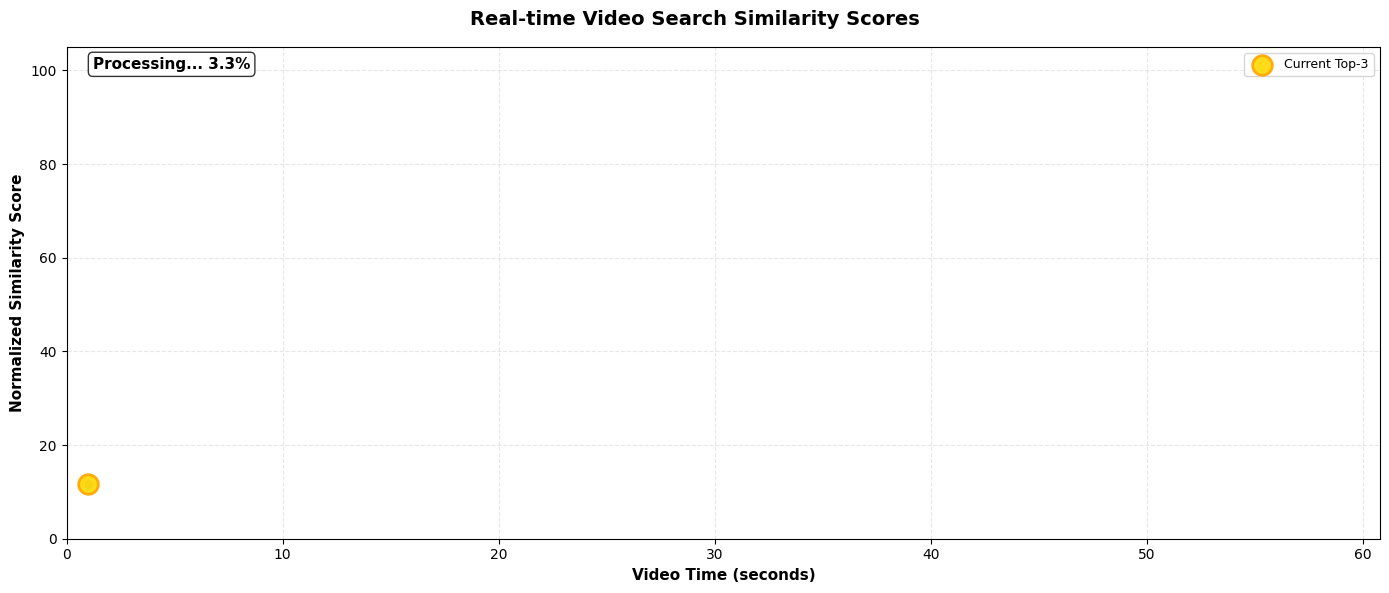

[Window 2/31] 처리 중: 0:00:02 - 0:00:04
  [Window 2/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 3/31] 처리 중: 0:00:04 - 0:00:06
  [Window 3/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 4/31] 처리 중: 0:00:06 - 0:00:08
  [Window 4/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 5/31] 처리 중: 0:00:08 - 0:00:10
  [Window 5/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 6/31] 처리 중: 0:00:10 - 0:00:12
  [Window 6/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 7/31] 처리 중: 0:00:12 - 0:00:14
  [Window 7/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 8/31] 처리 중: 0:00:14 - 0:00:16
  [Window 8/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 9/31] 처리 중: 0:00:16 - 0:00:18
  [Window 9/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 10/31] 처리 중: 0:00:18 - 0:00:20
  [Window 10/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 11/31] 처리 중: 0:00:20 - 0:00:22
  [Window 11/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 12/31] 처리 중: 0:00:22 - 0:00:24
  [Window 12/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 13/31] 처리 중: 0:00:24 - 0:00:26
  [Window 13/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 14/31] 처리 중: 0:00:26 - 0:00:28
  [Window 14/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 15/31] 처리 중: 0:00:28 - 0:00:30
  [Window 15/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 16/31] 처리 중: 0:00:30 - 0:00:32
  [Window 16/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 17/31] 처리 중: 0:00:32 - 0:00:34
  [Window 17/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 18/31] 처리 중: 0:00:34 - 0:00:36
  [Window 18/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 19/31] 처리 중: 0:00:36 - 0:00:38
  [Window 19/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 20/31] 처리 중: 0:00:38 - 0:00:40
  [Window 20/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 21/31] 처리 중: 0:00:40 - 0:00:42
  [Window 21/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 22/31] 처리 중: 0:00:42 - 0:00:44
  [Window 22/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 23/31] 처리 중: 0:00:44 - 0:00:46
  [Window 23/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 24/31] 처리 중: 0:00:46 - 0:00:48
  [Window 24/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 25/31] 처리 중: 0:00:48 - 0:00:50
  [Window 25/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 26/31] 처리 중: 0:00:50 - 0:00:52
  [Window 26/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 27/31] 처리 중: 0:00:52 - 0:00:54
  [Window 27/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 28/31] 처리 중: 0:00:54 - 0:00:56
  [Window 28/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 29/31] 처리 중: 0:00:56 - 0:00:58
  [Window 29/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 30/31] 처리 중: 0:00:58 - 0:01:00
  [Window 30/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.02초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>

[Window 31/31] 처리 중: 0:01:00 - 0:01:00
  [Window 31/31] 프레임 추출 중: 12/12
  -> 정규화 CLIP 점수: 11.69 (프레임 추출: 0.01초, CLIP 추론: 0.05초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 11.6882)



<Figure size 640x480 with 0 Axes>


[1차 검색 완료] CLIP 점수 기준 상위 3개 후보 선별
1. 0:00:00 - 0:00:02 - 점수: 11.6882
2. 0:00:02 - 0:00:04 - 점수: 11.6882
3. 0:00:04 - 0:00:06 - 점수: 11.6882

[2차 보정 시작] BLIP-2를 사용하여 상위 3개 후보 보정 중...

[후보 1/3] 0:00:00 - 0:00:02


/tmp/ipython-input-3328607815.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(sim.cpu().numpy())


  -> 생성된 캡션: a black background with a white clock on it
  -> 의미 유사도: 0.5889
  -> 최종 점수: 8.3584
  -> BLIP-2 처리 시간: 0.83초

[후보 2/3] 0:00:02 - 0:00:04
  -> 생성된 캡션: a black background with a white clock on it
  -> 의미 유사도: 0.5889
  -> 최종 점수: 8.3584
  -> BLIP-2 처리 시간: 0.40초

[후보 3/3] 0:00:04 - 0:00:06
  -> 생성된 캡션: a black background with a white clock on it
  -> 의미 유사도: 0.5889
  -> 최종 점수: 8.3584
  -> BLIP-2 처리 시간: 0.36초

[최종 순위]
1. 0:00:00 - 0:00:02 - 최종 점수: 8.3584
2. 0:00:02 - 0:00:04 - 최종 점수: 8.3584
3. 0:00:04 - 0:00:06 - 최종 점수: 8.3584



<Figure size 640x480 with 0 Axes>


[📊 시각화 완료] 최종 Top-3 결과가 빨간색 별(★)로 표시되었습니다!

  [시각화] 그래프 저장 완료: viz_CB_2.0, 12, 3, True, 0.7, 0.3_20260121_110841_test.png

[검색 완료] 결과가 CB_2.0, 12, 3, True, 0.7, 0.3_20260121_110841_test.json에 저장되었습니다.
[상세 점수 저장 완료] whole_score_CB_2.0, 12, 3, True, 0.7, 0.3_20260121_110841_test.json
  -> 총 31개 윈도우의 상세 점수 저장됨
[시각화 저장 완료] viz_CB_2.0, 12, 3, True, 0.7, 0.3_20260121_110841_test.png

📊 [전체 실행 시간 분석]
  ⏱️  총 실행 시간: 456.46초

  🔧 초기화 단계:
     - ModelManager 초기화: 447.95초
       ├─ CLIP 로드: 13.19초
       └─ BLIP-2 로드: 434.76초
     - VideoProcessor 초기화: 0.18초
     - 전체 초기화: 448.13초

  🔍 검색 단계:
     - API 호출 (쿼리 분석): 1.18초
     - 프레임 추출: 0.46초
     - CLIP 추론: 3.53초
     - BLIP-2 추론: 1.58초
     - 전체 검색: 7.15초



In [ ]:
# ==========================================
# 5. Main Execution
# ==========================================
def main():
    # 전역 변수 선언 (함수 안에서 전역 변수를 사용/수정하기 위해 필요)
    global model_manager, video_processor
    
    # 전체 실행 시간 측정 시작
    program_start_time = time.time()

    # --- Configurations ---
    VIDEO_PATH = "sample_video.mp4" # 준비된 비디오 파일 경로
    # VIDEO_PATH = "/kaggle/input/yai-17-w/sample_video.mp4" # 준비된 비디오 파일 경로
    SAVE_PATH = "results"
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
    else:
        print(f"Save path '{SAVE_PATH}' already exists. Results will be saved here.")
    QUERY = "바닥에 떨어진 신용카드"
    # "바닥에 떨어지는 카드를 보고 난감한 표정을 짓는 남자" # 테스트 쿼리

    # Experiments Parameters
    p_list = [2.0, 4.0]      # 윈도우 크기 (초)
    q_list = [12, 24, 48]         # 샘플링 프레임 수
    k_list = [3, 5]          # Top-K 개수
    STEP_SEC = 1.0           # 윈도우 이동 간격 (초) - 윈도우 크기보다 작으면 겹침
    WEIGHT_CLIP = 0.7
    WEIGHT_SEMANTIC = 0.3
    USE_LOOP = False         # 반복 실행 여부

    # Initialize
    if not os.path.exists(VIDEO_PATH):
        print(f"Error: Video file '{VIDEO_PATH}' not found. Please place a dummy video.")
        return

    # 초기화 시간 측정
    init_start_time = time.time()
    # Initialize (전역 변수로 저장)
    # 이미 초기화되었는지 확인
    
    # main() 함수 안 (1001줄 앞에 추가)
    print(f"[DEBUG] 'model_manager' in globals(): {'model_manager' in globals()}")
    if 'model_manager' in globals():
        print(f"[DEBUG] model_manager is None: {model_manager is None}")
        print(f"[DEBUG] model_manager 값: {model_manager}")
    
    if 'model_manager' not in globals() or model_manager is None:
        print("🔄 ModelManager 초기화 중...")
        init_start_time = time.time()
        model_manager = ModelManager(use_blip=USE_BLIP)
        print(f"✅ ModelManager 초기화 완료 ({time.time() - init_start_time:.2f}초)")
    else:
        print("♻️ 기존 ModelManager 재사용 (메모리 절약!)")
    if 'video_processor' not in globals() or video_processor is None:
        print("🔄 VideoProcessor 초기화 중...")
        video_processor = VideoProcessor(VIDEO_PATH)
        print(f"✅ VideoProcessor 초기화 완료 ({time.time() - init_start_time:.2f}초)")
    else:
        print("♻️ 기존 VideoProcessor 재사용 (메모리 절약!)")
    engine = AdaptiveSearchEngine(model_manager, video_processor)
    total_init_time = time.time() - init_start_time

    print(f"\n[쿼리 분석] '{QUERY}'")
    sub_queries, split_reason = engine.split_query(QUERY)
    print(f"[분할된 쿼리] {sub_queries}\n")

    # Experiment Loop
    # 반복 실행 할 때
    if USE_LOOP:
        for p in p_list:
            for q in q_list:
                for k in k_list:
                    print(f"\n--- Running Experiment: p={p}, q={q}, k={k} ---")

                    # Perform Search (실시간 시각화 활성화)
                    results, all_windows_data, visualizer = engine.search(QUERY, sub_queries, p, q, k, STEP_SEC, WEIGHT_CLIP, WEIGHT_SEMANTIC, enable_visualization=True, save_path=SAVE_PATH)

                    # 전체 실행 시간 계산
                    total_elapsed_time = time.time() - program_start_time

                    # Construct Filename
                    model_name = "CB" if USE_BLIP else "Clip"
                    timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                    # 유의미한 결과 나왔으면 _test.json 대신 .json 확장자 사용
                    filename = f"{model_name}_{p}, {q}, {k}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test.json"
                    filename_base = f"{model_name}_{p}, {q}, {k}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test"

                    # 시각화 저장
                    if visualizer:
                        try:
                            viz_filename = visualizer.save_and_close(filename_base)
                        except Exception as e:
                            print(f"  [시각화] 저장 실패: {e}")
                            viz_filename = None
                    else:
                        viz_filename = None

                    # 타이밍 정보 수집
                    timing_data = collect_timing_data(total_elapsed_time, total_init_time, 
                                                    model_manager, video_processor, engine)

                    # Output Data Structure
                    output_data = {
                        "meta": {
                            "video_path": VIDEO_PATH,
                            "query": QUERY,
                            "sub_queries": sub_queries,
                            "split_reason": split_reason,
                            "parameters": {"p": p, "q": q, "k": k, "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                            "model": model_name,
                            "timestamp": timestamp_str
                        },
                        "time_used": timing_data,
                        "results": results
                    }

                    # Save to JSON
                    with open(os.path.join(SAVE_PATH, filename), "w", encoding='utf-8') as f:
                        json.dump(output_data, f, indent=4, ensure_ascii=False)

                    # 모든 윈도우의 상세 점수 저장
                    whole_score_filename = f"whole_score_{filename}"
                    whole_score_data = {
                        "meta": {
                            "video_path": VIDEO_PATH,
                            "query": QUERY,
                            "sub_queries": sub_queries,
                            "parameters": {"p": p, "q": q, "k": k, "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                            "total_windows": len(all_windows_data),
                            "timestamp": timestamp_str
                        },
                        "all_windows": all_windows_data
                    }
                    with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding='utf-8') as f:
                        json.dump(whole_score_data, f, indent=4, ensure_ascii=False)

                    print(f"\n[저장 완료] {filename}")
                    print(f"[상세 점수 저장 완료] {whole_score_filename}")
                    print(f"  -> 총 {len(all_windows_data)}개 윈도우의 상세 점수 저장됨")
                    if viz_filename:
                        print(f"[시각화 저장 완료] {viz_filename}")
                    print(f"[총 실행 시간] {total_elapsed_time:.2f}초\n")
                    cleanup_temp_images(SAVE_PATH)

    # 반복 실행 아닐 때
    else:
        results, all_windows_data, visualizer = engine.search(QUERY, sub_queries, p_list[0], q_list[0], k_list[0], STEP_SEC, WEIGHT_CLIP, WEIGHT_SEMANTIC, enable_visualization=True, save_path=SAVE_PATH)

        # 전체 실행 시간 계산
        total_elapsed_time = time.time() - program_start_time

        model_name = "CB" if USE_BLIP else "Clip"
        timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{model_name}_{p_list[0]}, {q_list[0]}, {k_list[0]}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test.json"
        filename_base = f"{model_name}_{p_list[0]}, {q_list[0]}, {k_list[0]}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test"

        # 시각화 저장
        if visualizer:
            try:
                viz_filename = visualizer.save_and_close(filename_base)
            except Exception as e:
                print(f"  [시각화] 저장 실패: {e}")
                viz_filename = None
        else:
            viz_filename = None

        # 타이밍 정보 수집
        timing_data = collect_timing_data(total_elapsed_time, total_init_time, 
                                        model_manager, video_processor, engine)

        # Output Data Structure
        output_data = {
            "meta": {
                "video_path": VIDEO_PATH,
                "query": QUERY,
                "sub_queries": sub_queries,
                "split_reason": split_reason,
                "parameters": {"p": p_list[0], "q": q_list[0], "k": k_list[0], "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                "model": model_name,
                "timestamp": timestamp_str
            },
            "time_used": timing_data,
            "results": results
        }

        # Save to JSON
        with open(os.path.join(SAVE_PATH, filename), "w", encoding='utf-8') as f:
            json.dump(output_data, f, indent=4, ensure_ascii=False)

        # 모든 윈도우의 상세 점수 저장
        whole_score_filename = f"whole_score_{filename}"
        whole_score_data = {
            "meta": {
                "video_path": VIDEO_PATH,
                "query": QUERY,
                "sub_queries": sub_queries,
                "parameters": {"p": p_list[0], "q": q_list[0], "k": k_list[0], "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                "total_windows": len(all_windows_data),
                "timestamp": timestamp_str
            },
            "all_windows": all_windows_data
        }
        with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding='utf-8') as f:
            json.dump(whole_score_data, f, indent=4, ensure_ascii=False)

        print(f"\n{'='*60}")
        print(f"[검색 완료] 결과가 {filename}에 저장되었습니다.")
        print(f"[상세 점수 저장 완료] {whole_score_filename}")
        print(f"  -> 총 {len(all_windows_data)}개 윈도우의 상세 점수 저장됨")
        if viz_filename:
            print(f"[시각화 저장 완료] {viz_filename}")
        print(f"{'='*60}")
        print(f"\n📊 [전체 실행 시간 분석]")
        print(f"{'='*60}")
        print(f"  ⏱️  총 실행 시간: {total_elapsed_time:.2f}초")
        print(f"\n  🔧 초기화 단계:")
        print(f"     - ModelManager 초기화: {model_manager.init_time:.2f}초")
        print(f"       ├─ CLIP 로드: {model_manager.clip_load_time:.2f}초")
        print(f"       └─ BLIP-2 로드: {model_manager.blip_load_time:.2f}초")
        print(f"     - VideoProcessor 초기화: {video_processor.init_time:.2f}초")
        print(f"     - 전체 초기화: {total_init_time:.2f}초")
        print(f"\n  🔍 검색 단계:")
        print(f"     - API 호출 (쿼리 분석): {engine.timing_info['api_call_time']:.2f}초")
        print(f"     - 프레임 추출: {engine.timing_info['frame_extraction_time']:.2f}초")
        print(f"     - CLIP 추론: {engine.timing_info['clip_inference_time']:.2f}초")
        if USE_BLIP:
            print(f"     - BLIP-2 추론: {engine.timing_info['blip_inference_time']:.2f}초")
        print(f"     - 전체 검색: {engine.timing_info['total_search_time']:.2f}초")
        print(f"{'='*60}\n")
        cleanup_temp_images(SAVE_PATH)

if __name__ == "__main__":
    main()

## 8. 실행 예제

위의 main() 함수를 실행하거나, 아래처럼 직접 실행할 수 있습니다:


In [ ]:
# 주석을 제거하고 실행하세요
# main()